# Where do the water masses go in the Salish Sea?
Using the same water mass seperations as in CIOPS

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import datetime as dt

import cmocean as cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from dateutil.relativedelta import relativedelta
%matplotlib inline

In [2]:
def get_data(mydata, starttime, endtime, time):
    salt = mydata.init_salt[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    temp = mydata.init_t[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    depth = depthf(mydata.init_z[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]-1.)[0]
    section = mydata.final_section[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    trans = mydata.init_transp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/(time)
    lons = mydata.final_lon[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    return salt, temp, depth, section, trans, lons

In [3]:
mymesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

In [4]:
# section numbers
meander = 0
admiralty = 2
deception = 3
rosario = 4
sanjuan = 5
haro = 6
sec_name = ['meander', 'admiralty', 'deception', 'rosario', 'sanjuan', 'haro']

In [6]:
def draw_patches(fmask, lonW, lonE, t_dist, t_depths): #draw ground part of cross section
    topo = []
    for i in range(lonW,lonE):
        for j in range(39):
            if fmask[j, i] == 0:
                rect = Rectangle((t_dist[i], t_depths[j]), t_dist[i+1]-t_dist[i], t_depths[j+1]-t_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='lightgray', zorder=3)
    return(pc)

In [7]:
#lets make a fun lil matrix with all of the info we need about every channel to run the cross-section code
#in the format [section, jgridW, jgridE, figrid, maxdepth]
admiralty = [2, 255, 267, 204, 100]
rosario = [4, 286, 307, 266, 100]
sanjuan = [5, 264, 266, 280, 100]
haro = [6, 218, 242, 304, 300]

#in the format [section, jgridS, jgridN, figrid, maxdepth]
decep = [3, 246, 247, 309, 20]

In [81]:
def FluxCS(lonW, lonE, figrid, maxdepth, ax, lons, depths, transports):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
#     time = 720
    
#     lons = mydata.init_lon[(mydata.final_section != 0)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum())).values
#     print(m2lon)
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
#     depths = depthf(mydata.init_z[(mydata.final_section != 0)]-1.)[0]
#     transports = mydata.init_transp[(mydata.final_section != 0)]/time
    
    vmax = 1/sum(transports)
    
    H, xedges, yedges = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transports, density= True)
    H = np.where(H>0, H, H*np.nan)

    X, Y = np.meshgrid(xedges, yedges)
    cmap = cm.cm.speed
    cmap.set_bad('white')
    im = ax.pcolormesh(X, Y, H.T, vmax = vmax, vmin = 0, cmap=cmap)

    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, vmax])
    cb1.set_ticklabels([0, np.round(((vmax * sum(transports))),2)]) 
    cb1.set_label('m s$^{-1}$', labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks([t_dist[lonW+1], t_dist[lonE-1]])
    ax.set_ylabel('Depth [m]')
    ax.set_xticklabels(np.round([t_lons[lonW+1], t_lons[lonE-1]],2))
    ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
#     ax.set_title(str(title))
    mydata.close()

## summer 2017

In [61]:
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
sum_start = 1+(5*720+(sum(yearjumps[:5+1]*24)))
sum_end = 720+(8*720+(sum(yearjumps[:8+1]*24)))

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt, temp, depth, section, trans, lons = get_data(mydata, sum_start, sum_end, sum_end-sum_start+1)

In [62]:
d = {'salt': salt, 'temp': temp, 'depth':depth, 'section':section, 'transport':trans, 'lon':lons}
dfS = pd.DataFrame(data=d)

In [94]:
upwelled = dfS[(dfS.depth <= 200) & (dfS.salt >= 32)]
cuc = dfS[(dfS.depth > 200) & (dfS.salt >= 32)]
columbia = dfS[(dfS.salt < 32)]

In [8]:
[np.sum(upwelled.transport)/np.sum(df.transport)*100,np.sum(cuc.transport)/np.sum(df.transport)*100,
np.sum(columbia.transport)/np.sum(df.transport)*100]

[82.48644651961337, 6.267863370364149, 11.245690110022469]

In [9]:
# lets see what sections these groups get into 
# first upwelled
print('advects back out = ' + str(sum(upwelled.transport[upwelled.section == meander])/np.sum(upwelled.transport)*100))
print('haro = ' + str(sum(upwelled.transport[upwelled.section == haro])/np.sum(upwelled.transport)*100))
print('sanjuan = ' + str(sum(upwelled.transport[upwelled.section == sanjuan])/np.sum(upwelled.transport)*100))
print('rosario = ' + str(sum(upwelled.transport[upwelled.section == rosario])/np.sum(upwelled.transport)*100))
print('admiralty = ' + str(sum(upwelled.transport[upwelled.section == admiralty])/np.sum(upwelled.transport)*100))
print('deception = ' + str(sum(upwelled.transport[upwelled.section == deception])/np.sum(upwelled.transport)*100))

advects back out = 78.86193130464324
haro = 15.036141234040171
sanjuan = 0.8025543181691127
rosario = 1.6676706078259846
admiralty = 3.61407399127876
deception = 0.017539038600961242


In [10]:
# and deep
print('advects back out = ' + str(sum(cuc.transport[cuc.section == meander])/np.sum(cuc.transport)*100))
print('haro = ' + str(sum(cuc.transport[cuc.section == haro])/np.sum(cuc.transport)*100))
print('sanjuan = ' + str(sum(cuc.transport[cuc.section == sanjuan])/np.sum(cuc.transport)*100))
print('rosario = ' + str(sum(cuc.transport[cuc.section == rosario])/np.sum(cuc.transport)*100))
print('admiralty = ' + str(sum(cuc.transport[cuc.section == admiralty])/np.sum(cuc.transport)*100))
print('deception = ' + str(sum(cuc.transport[cuc.section == deception])/np.sum(cuc.transport)*100))

advects back out = 88.46222790645251
haro = 8.610096977372251
sanjuan = 0.4545295871380527
rosario = 0.8177067747539721
admiralty = 1.6480737956203904
deception = 0.007364958662847872


In [11]:
# columbia 
print('advects back out = ' + str(sum(columbia.transport[columbia.section == meander])/np.sum(columbia.transport)*100))
print('haro = ' + str(sum(columbia.transport[columbia.section == haro])/np.sum(columbia.transport)*100))
print('sanjuan = ' + str(sum(columbia.transport[columbia.section == sanjuan])/np.sum(columbia.transport)*100))
print('rosario = ' + str(sum(columbia.transport[columbia.section == rosario])/np.sum(columbia.transport)*100))
print('admiralty = ' + str(sum(columbia.transport[columbia.section == admiralty])/np.sum(columbia.transport)*100))
print('deception = ' + str(sum(columbia.transport[columbia.section == deception])/np.sum(columbia.transport)*100))

advects back out = 99.92800893015723
haro = 0.043914367160181295
sanjuan = 0.0019204581578246885
rosario = 0.0067040129977496985
admiralty = 0.01945223152815096
deception = 0.0


In [78]:
time = 720*4

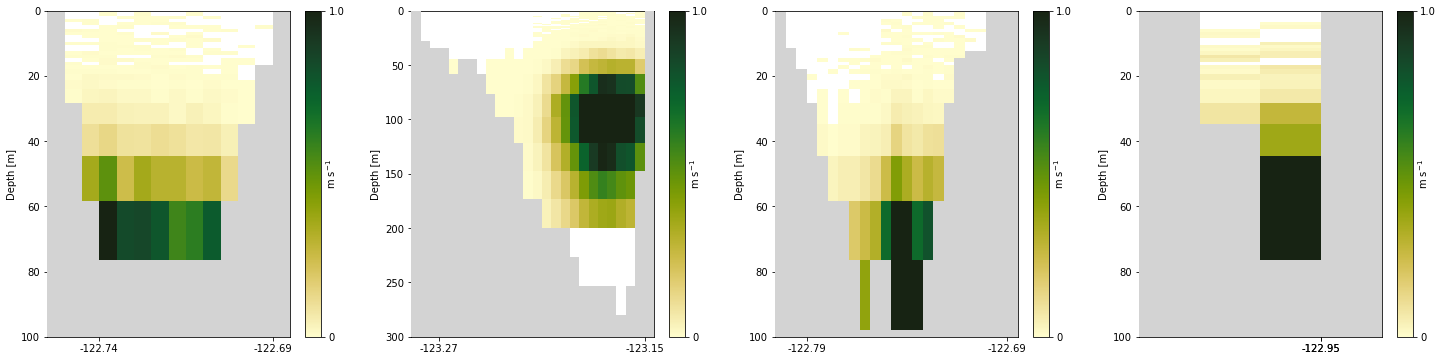

In [96]:
fig, ax = plt.subplots(1,4,figsize=(25,6))
FluxCS(admiralty[1], admiralty[2], admiralty[3], admiralty[4], ax[0], np.array(upwelled.lon), np.array(upwelled.depth), np.array(upwelled.transport))
FluxCS(haro[1], haro[2], haro[3], haro[4], ax[1], np.array(upwelled.lon), np.array(upwelled.depth), np.array(upwelled.transport))
FluxCS(rosario[1], rosario[2], rosario[3], rosario[4], ax[2], np.array(upwelled.lon), np.array(upwelled.depth), np.array(upwelled.transport))
FluxCS(sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], ax[3], np.array(upwelled.lon), np.array(upwelled.depth), np.array(upwelled.transport))

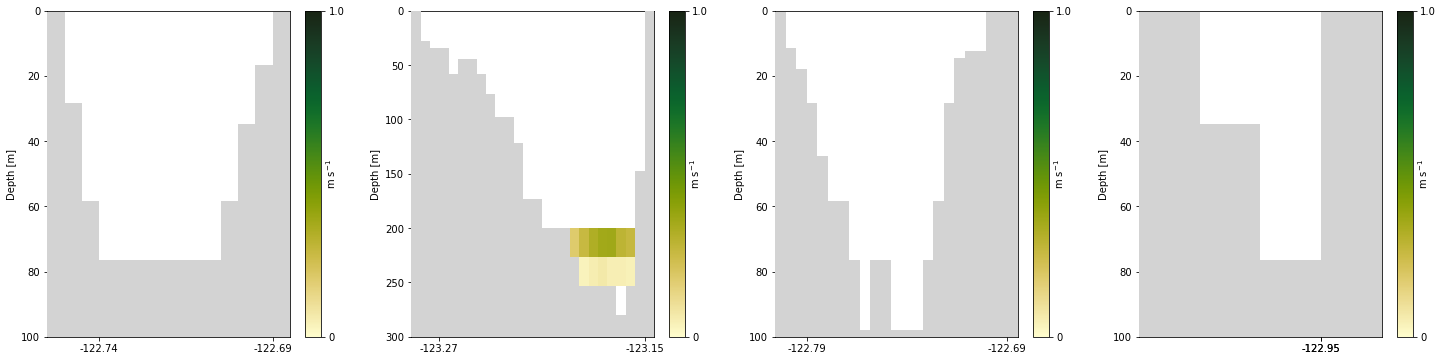

In [97]:
fig, ax = plt.subplots(1,4,figsize=(25,6))
FluxCS(admiralty[1], admiralty[2], admiralty[3], admiralty[4], ax[0], cuc.lon, cuc.depth, cuc.transport)
FluxCS(haro[1], haro[2], haro[3], haro[4], ax[1], cuc.lon, cuc.depth, cuc.transport)
FluxCS(rosario[1], rosario[2], rosario[3], rosario[4], ax[2], cuc.lon, cuc.depth, cuc.transport)
FluxCS(sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], ax[3], cuc.lon, cuc.depth, cuc.transport)

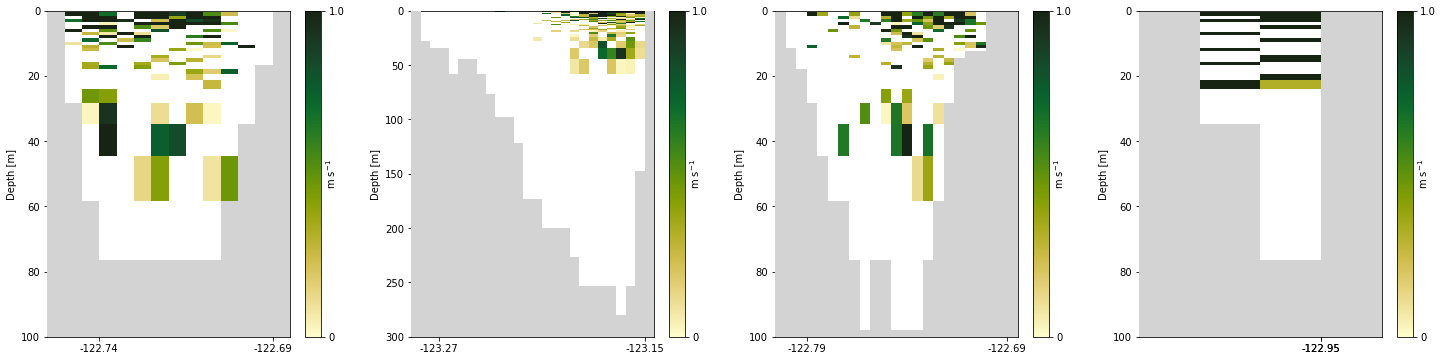

In [98]:
fig, ax = plt.subplots(1,4,figsize=(25,6))
FluxCS(admiralty[1], admiralty[2], admiralty[3], admiralty[4], ax[0], columbia.lon, columbia.depth, columbia.transport)
FluxCS(haro[1], haro[2], haro[3], haro[4], ax[1], columbia.lon, columbia.depth, columbia.transport)
FluxCS(rosario[1], rosario[2], rosario[3], rosario[4], ax[2], columbia.lon, columbia.depth, columbia.transport)
FluxCS(sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], ax[3], columbia.lon, columbia.depth, columbia.transport)

## Winter 2016/17

In [83]:
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
win_start1 = 1+(9*720+(sum(yearjumps[:9+1]*24)))
win_end1 = 720+(11*720+(sum(yearjumps[:11+1]*24)))

win_start2 = 1+(0*720+(sum(yearjumps[:0+1]*24)))
win_end2 = 720+(5*720+(sum(yearjumps[:5+1]*24)))

time = (win_end1-win_start1+1) + (win_end2-win_start2+1)

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
saltW, tempW, depthW, sectionW, transW, lonsW = get_data(mydata, win_start1, win_end1, time)

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
saltS, tempS, depthS, sectionS, transS, lonsS = get_data(mydata, win_start2, win_end2, time)

salt = np.append(saltW, saltS)
temp = np.append(tempW, tempS)
depth = np.append(depthW, depthS)
section = np.append(sectionW, sectionS)
trans = np.append(transW, transS)
lons = np.append(lonsW, lonsS)

In [84]:
d = {'salt': salt, 'temp': temp, 'depth':depth, 'section':section, 'transport':trans, 'lon': lons}
dfW16 = pd.DataFrame(data=d)

In [99]:
upwelled = dfW16[(dfW16.depth <= 200) & (dfW16.salt >= 32)]
cuc = dfW16[(dfW16.depth > 200) & (dfW16.salt >= 32)]
columbia = dfW16[(dfW16.salt < 32)]

In [15]:
[np.sum(upwelled.transport)/np.sum(df.transport)*100,np.sum(cuc.transport)/np.sum(df.transport)*100,
np.sum(columbia.transport)/np.sum(df.transport)*100]

[63.403783973964146, 6.166366356170525, 30.429849669865423]

In [16]:
# lets see what sections these groups get into 
# first upwelled
print('advects back out = ' + str(sum(upwelled.transport[upwelled.section == meander])/np.sum(upwelled.transport)*100))
print('haro = ' + str(sum(upwelled.transport[upwelled.section == haro])/np.sum(upwelled.transport)*100))
print('sanjuan = ' + str(sum(upwelled.transport[upwelled.section == sanjuan])/np.sum(upwelled.transport)*100))
print('rosario = ' + str(sum(upwelled.transport[upwelled.section == rosario])/np.sum(upwelled.transport)*100))
print('admiralty = ' + str(sum(upwelled.transport[upwelled.section == admiralty])/np.sum(upwelled.transport)*100))
print('deception = ' + str(sum(upwelled.transport[upwelled.section == deception])/np.sum(upwelled.transport)*100))

advects back out = 86.20518281324941
haro = 9.097603288118055
sanjuan = 0.53019990239909
rosario = 0.9464089207634625
admiralty = 3.0111675182564492
deception = 0.010073688376884028


In [17]:
# and deep
print('advects back out = ' + str(sum(cuc.transport[cuc.section == meander])/np.sum(cuc.transport)*100))
print('haro = ' + str(sum(cuc.transport[cuc.section == haro])/np.sum(cuc.transport)*100))
print('sanjuan = ' + str(sum(cuc.transport[cuc.section == sanjuan])/np.sum(cuc.transport)*100))
print('rosario = ' + str(sum(cuc.transport[cuc.section == rosario])/np.sum(cuc.transport)*100))
print('admiralty = ' + str(sum(cuc.transport[cuc.section == admiralty])/np.sum(cuc.transport)*100))
print('deception = ' + str(sum(cuc.transport[cuc.section == deception])/np.sum(cuc.transport)*100))

advects back out = 93.48854029970028
haro = 4.305421294243852
sanjuan = 0.260153862976561
rosario = 0.4206077366042773
admiralty = 1.3420340829031492
deception = 0.0028524863047357826


In [18]:
# columbia 
print('advects back out = ' + str(sum(columbia.transport[columbia.section == meander])/np.sum(columbia.transport)*100))
print('haro = ' + str(sum(columbia.transport[columbia.section == haro])/np.sum(columbia.transport)*100))
print('sanjuan = ' + str(sum(columbia.transport[columbia.section == sanjuan])/np.sum(columbia.transport)*100))
print('rosario = ' + str(sum(columbia.transport[columbia.section == rosario])/np.sum(columbia.transport)*100))
print('admiralty = ' + str(sum(columbia.transport[columbia.section == admiralty])/np.sum(columbia.transport)*100))
print('deception = ' + str(sum(columbia.transport[columbia.section == deception])/np.sum(columbia.transport)*100))

advects back out = 97.85569637029515
haro = 1.1634320828212685
sanjuan = 0.09707726678581699
rosario = 0.14877661649244175
admiralty = 0.7172346426113841
deception = 0.0017962889823965333


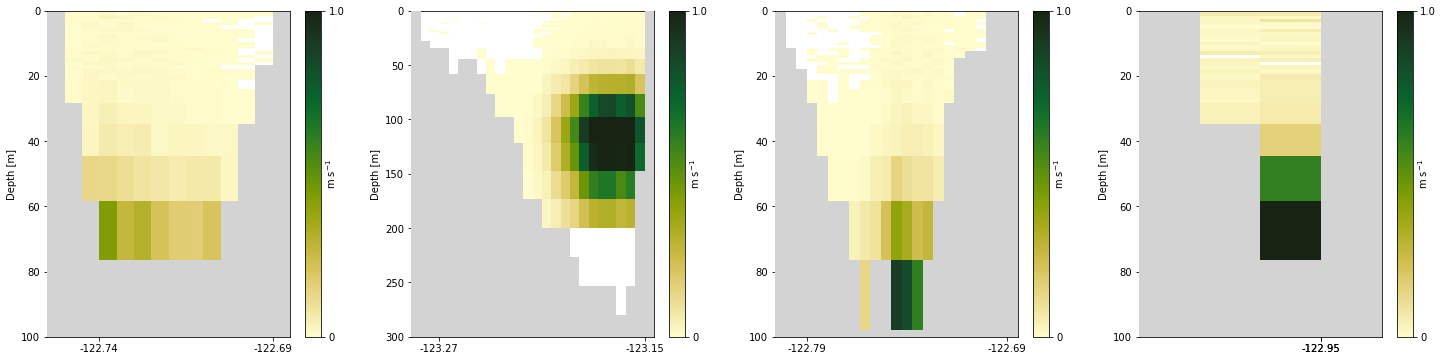

In [103]:
fig, ax = plt.subplots(1,4,figsize=(25,6))
FluxCS(admiralty[1], admiralty[2], admiralty[3], admiralty[4], ax[0], upwelled.lon, upwelled.depth, upwelled.transport)
FluxCS(haro[1], haro[2], haro[3], haro[4], ax[1], upwelled.lon, upwelled.depth, upwelled.transport)
FluxCS(rosario[1], rosario[2], rosario[3], rosario[4], ax[2], upwelled.lon, upwelled.depth, upwelled.transport)
FluxCS(sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], ax[3], upwelled.lon, upwelled.depth, upwelled.transport)

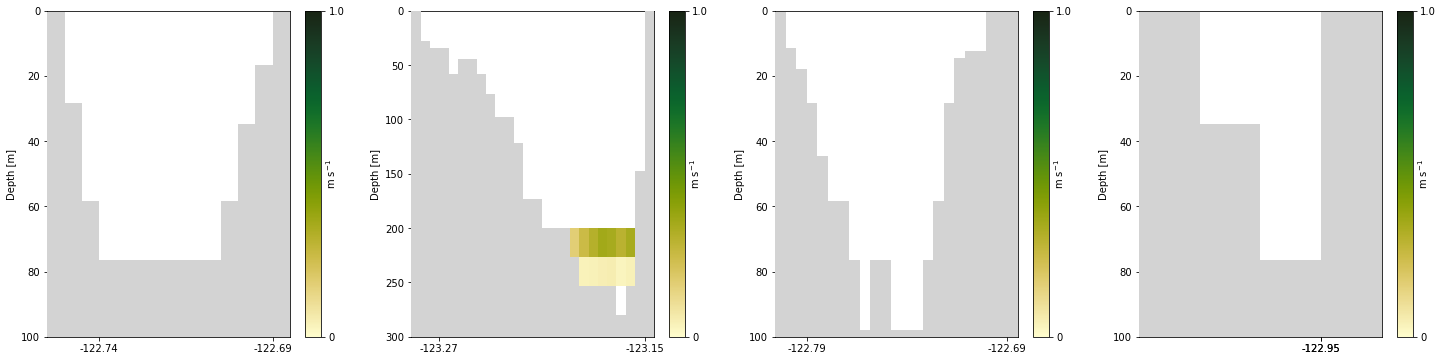

In [102]:
fig, ax = plt.subplots(1,4,figsize=(25,6))
FluxCS(admiralty[1], admiralty[2], admiralty[3], admiralty[4], ax[0], cuc.lon, cuc.depth, cuc.transport)
FluxCS(haro[1], haro[2], haro[3], haro[4], ax[1], cuc.lon, cuc.depth, cuc.transport)
FluxCS(rosario[1], rosario[2], rosario[3], rosario[4], ax[2], cuc.lon, cuc.depth, cuc.transport)
FluxCS(sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], ax[3], cuc.lon, cuc.depth, cuc.transport)

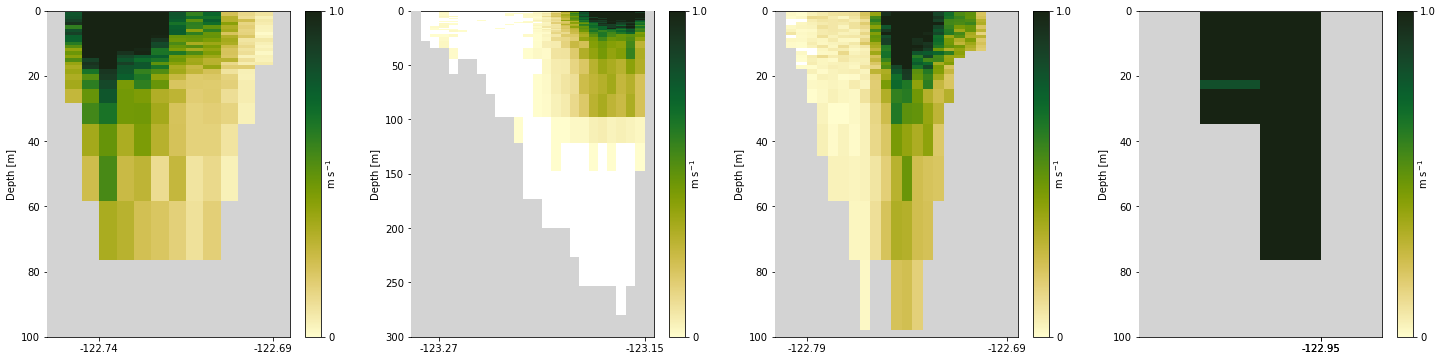

In [100]:
fig, ax = plt.subplots(1,4,figsize=(25,6))
FluxCS(admiralty[1], admiralty[2], admiralty[3], admiralty[4], ax[0], columbia.lon, columbia.depth, columbia.transport)
FluxCS(haro[1], haro[2], haro[3], haro[4], ax[1], columbia.lon, columbia.depth, columbia.transport)
FluxCS(rosario[1], rosario[2], rosario[3], rosario[4], ax[2], columbia.lon, columbia.depth, columbia.transport)
FluxCS(sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], ax[3], columbia.lon, columbia.depth, columbia.transport)

## Winter 2017/18

In [88]:
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
win_start = 1+(9*720+(sum(yearjumps[:9+1]*24)))
win_end = 720+(11*720+(sum(yearjumps[:11+1]*24)))

time = win_end-win_start+1+720*3

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt17, temp17, depth17, section17, trans17, lons17 = get_data(mydata, win_start, win_end, time)

start = 1
end = 720

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01jan18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt_jan, temp_jan, depth_jan, section_jan, trans_jan, lons_jan = get_data(mydata, start, end, time)

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01feb18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt_feb, temp_feb, depth_feb, section_feb, trans_feb, lons_feb = get_data(mydata, start, end, time)

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01mar18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt_mar, temp_mar, depth_mar, section_mar, trans_mar, lons_mar = get_data(mydata, start, end, time)

salt = np.append(np.append(np.append(salt17, salt_jan), salt_feb), salt_mar)
temp = np.append(np.append(np.append(temp17, temp_jan), temp_feb), temp_mar)
depth = np.append(np.append(np.append(depth17, depth_jan), depth_feb), depth_mar)
section = np.append(np.append(np.append(section17, section_jan), section_feb), section_mar)
trans = np.append(np.append(np.append(trans17, trans_jan), trans_feb), trans_mar)
lons = np.append(np.append(np.append(lons17, lons_jan), lons_feb), lons_mar)

In [89]:
d = {'salt': salt, 'temp': temp, 'depth':depth, 'section':section, 'transport':trans, 'lon':lons}
dfW17 = pd.DataFrame(data=d)

In [104]:
upwelled = dfW17[(dfW17.depth <= 200) & (dfW17.salt >= 32)]
cuc = dfW17[(dfW17.depth > 200) & (dfW17.salt >= 32)]
columbia = dfW17[(dfW17.salt < 32)]

In [22]:
[np.sum(upwelled.transport)/np.sum(df.transport)*100,np.sum(cuc.transport)/np.sum(df.transport)*100,
np.sum(columbia.transport)/np.sum(df.transport)*100]

[64.51913894995195, 6.095397136901457, 29.38546391314661]

In [23]:
# lets see what sections these groups get into 
# first upwelled
print('advects back out = ' + str(sum(upwelled.transport[upwelled.section == meander])/np.sum(upwelled.transport)*100))
print('haro = ' + str(sum(upwelled.transport[upwelled.section == haro])/np.sum(upwelled.transport)*100))
print('sanjuan = ' + str(sum(upwelled.transport[upwelled.section == sanjuan])/np.sum(upwelled.transport)*100))
print('rosario = ' + str(sum(upwelled.transport[upwelled.section == rosario])/np.sum(upwelled.transport)*100))
print('admiralty = ' + str(sum(upwelled.transport[upwelled.section == admiralty])/np.sum(upwelled.transport)*100))
print('deception = ' + str(sum(upwelled.transport[upwelled.section == deception])/np.sum(upwelled.transport)*100))

advects back out = 85.9074923365857
haro = 8.602617816895028
sanjuan = 0.5376347724680806
rosario = 0.8684338590656555
admiralty = 2.9866354265755346
deception = 0.010135156206366625


In [24]:
# and deep
print('advects back out = ' + str(sum(cuc.transport[cuc.section == meander])/np.sum(cuc.transport)*100))
print('haro = ' + str(sum(cuc.transport[cuc.section == haro])/np.sum(cuc.transport)*100))
print('sanjuan = ' + str(sum(cuc.transport[cuc.section == sanjuan])/np.sum(cuc.transport)*100))
print('rosario = ' + str(sum(cuc.transport[cuc.section == rosario])/np.sum(cuc.transport)*100))
print('admiralty = ' + str(sum(cuc.transport[cuc.section == admiralty])/np.sum(cuc.transport)*100))
print('deception = ' + str(sum(cuc.transport[cuc.section == deception])/np.sum(cuc.transport)*100))

advects back out = 92.6043680365625
haro = 4.5736470339224535
sanjuan = 0.2979765798597585
rosario = 0.47534916550493256
admiralty = 1.3799345621068348
deception = 0.0064622023368504766


In [25]:
# columbia 
print('advects back out = ' + str(sum(columbia.transport[columbia.section == meander])/np.sum(columbia.transport)*100))
print('haro = ' + str(sum(columbia.transport[columbia.section == haro])/np.sum(columbia.transport)*100))
print('sanjuan = ' + str(sum(columbia.transport[columbia.section == sanjuan])/np.sum(columbia.transport)*100))
print('rosario = ' + str(sum(columbia.transport[columbia.section == rosario])/np.sum(columbia.transport)*100))
print('admiralty = ' + str(sum(columbia.transport[columbia.section == admiralty])/np.sum(columbia.transport)*100))
print('deception = ' + str(sum(columbia.transport[columbia.section == deception])/np.sum(columbia.transport)*100))

advects back out = 97.5227071696774
haro = 1.1339700976419966
sanjuan = 0.08780541379432083
rosario = 0.16373876709214663
admiralty = 0.9096707882284927
deception = 0.0033608758785290643


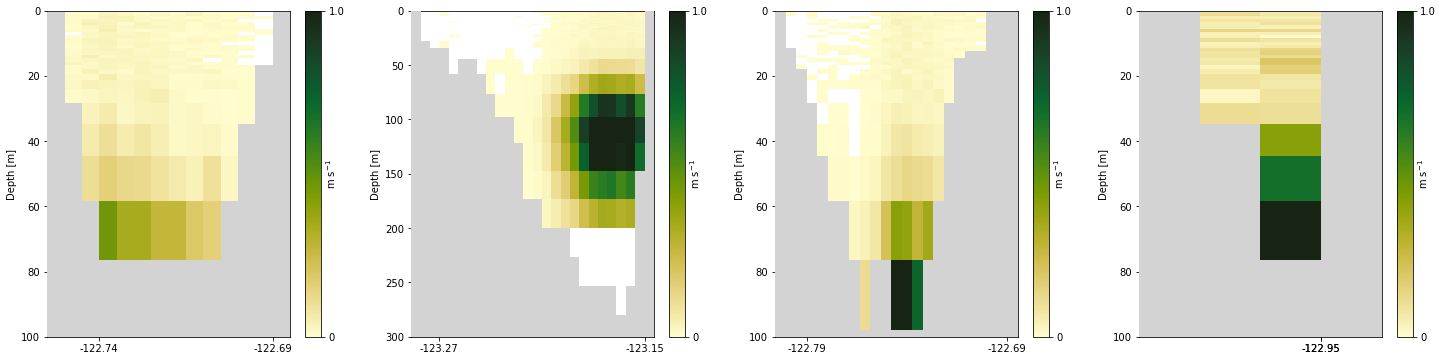

In [107]:
fig, ax = plt.subplots(1,4,figsize=(25,6))
FluxCS(admiralty[1], admiralty[2], admiralty[3], admiralty[4], ax[0], upwelled.lon, upwelled.depth, upwelled.transport)
FluxCS(haro[1], haro[2], haro[3], haro[4], ax[1], upwelled.lon, upwelled.depth, upwelled.transport)
FluxCS(rosario[1], rosario[2], rosario[3], rosario[4], ax[2], upwelled.lon, upwelled.depth, upwelled.transport)
FluxCS(sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], ax[3], upwelled.lon, upwelled.depth, upwelled.transport)

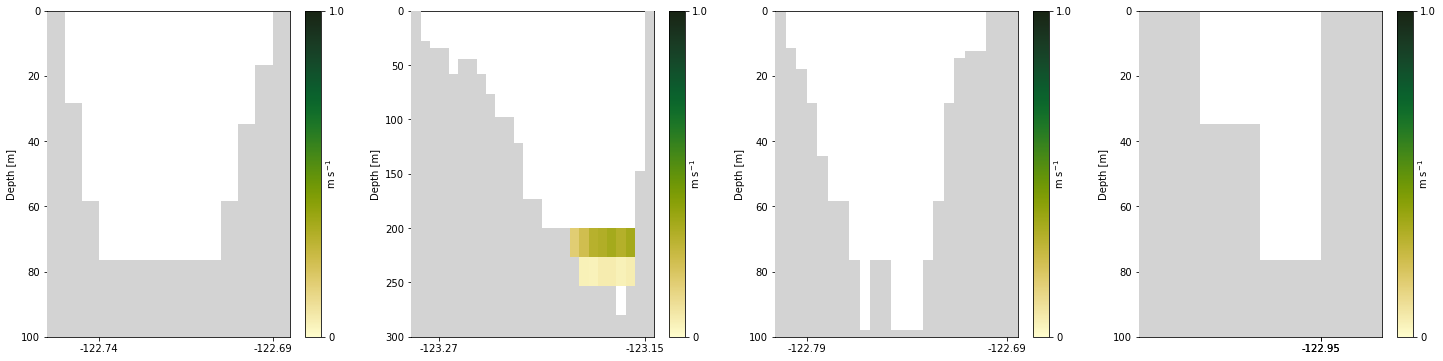

In [106]:
fig, ax = plt.subplots(1,4,figsize=(25,6))
FluxCS(admiralty[1], admiralty[2], admiralty[3], admiralty[4], ax[0], cuc.lon, cuc.depth, cuc.transport)
FluxCS(haro[1], haro[2], haro[3], haro[4], ax[1], cuc.lon, cuc.depth, cuc.transport)
FluxCS(rosario[1], rosario[2], rosario[3], rosario[4], ax[2], cuc.lon, cuc.depth, cuc.transport)
FluxCS(sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], ax[3], cuc.lon, cuc.depth, cuc.transport)

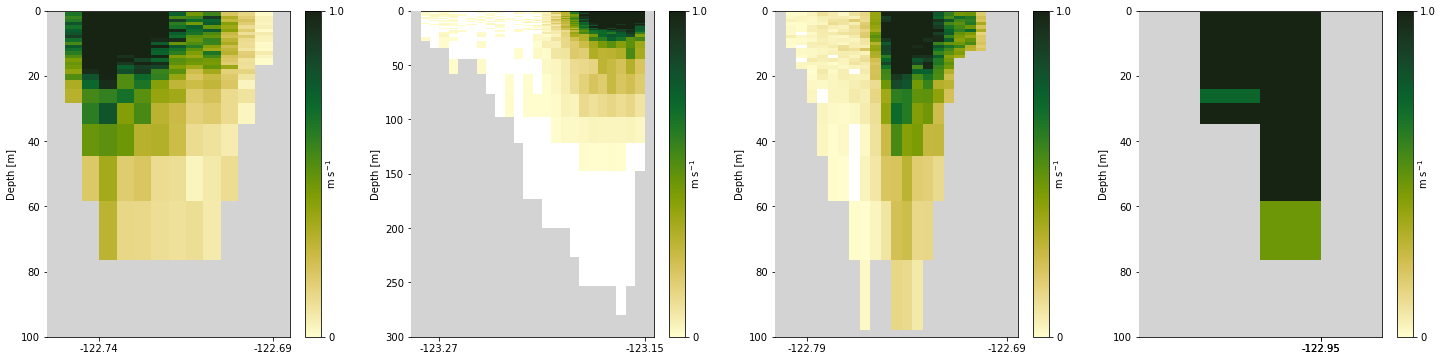

In [105]:
fig, ax = plt.subplots(1,4,figsize=(25,6))
FluxCS(admiralty[1], admiralty[2], admiralty[3], admiralty[4], ax[0], columbia.lon, columbia.depth, columbia.transport)
FluxCS(haro[1], haro[2], haro[3], haro[4], ax[1], columbia.lon, columbia.depth, columbia.transport)
FluxCS(rosario[1], rosario[2], rosario[3], rosario[4], ax[2], columbia.lon, columbia.depth, columbia.transport)
FluxCS(sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], ax[3], columbia.lon, columbia.depth, columbia.transport)

# plots of water masses to straits or meander?

In [28]:
starttime = 1
endtime = 720
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]

freshSOG = np.array([])
# freshOUT = np.array([])
freshPS = np.array([])
    
cucSOG = np.array([])
# cucOUT = np.array([])
cucPS = np.array([])
    
upSOG = np.array([])
# upOUT = np.array([])
upPS = np.array([])
# k = np.array([])
SoG = np.array([])
PS = np.array([])


#216 and 2017
year = [16,17]

for num in year:
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan'+str(num)+'/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(12):
        start, end = starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24)))
        
        XSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan))& (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception)) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        
        XfreshSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan)) & (mydata.init_salt < 32) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XfreshPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception)) & (mydata.init_salt < 32) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
#         XfreshOUT = np.sum(mydata.final_transp[(mydata.final_section==meander) & (mydata.init_salt < 32) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720

        XcucSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan)) & (mydata.init_salt >= 32) & (mydata.init_depth < -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XcucPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception)) & (mydata.init_salt >= 32) & (mydata.init_depth < -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
#         XcucOUT = np.sum(mydata.final_transp[(mydata.final_section==meander) & (mydata.init_salt >= 32) & (mydata.init_depth < -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720

        XupSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan)) & (mydata.init_salt >= 32) & (mydata.init_depth >= -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XupPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception)) & (mydata.init_salt >= 32) & (mydata.init_depth >= -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
#         XupOUT = np.sum(mydata.final_transp[(mydata.final_section==meander) & (mydata.init_salt >= 32) & (mydata.init_depth >= -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
            
        freshSOG = np.append(freshSOG, XfreshSOG)
#         freshOUT = np.append(freshOUT, XfreshOUT)
        freshPS = np.append(freshPS, XfreshPS)

        cucSOG = np.append(cucSOG, XcucSOG)
#         cucOUT = np.append(cucOUT, XcucOUT)
        cucPS = np.append(cucPS, XcucPS)

        upSOG = np.append(upSOG, XupSOG)
#         upOUT = np.append(upOUT, XupOUT)
        upPS = np.append(upPS, XupPS)
    
        SoG = np.append(SoG, XSOG)
        PS = np.append(PS, XPS)
            
#         k = np.append(k,i)

#2019 and 2018 (both done month by month)
year = [18,19]
str_mo = ['jan', 'feb', 'mar', 'apr', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
for num in year:
    for i in range(len(str_mo)):
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01'+str_mo[i]+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        time = mydata.init_t[-1]

        start, end = 1, 720
        
        XSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan))])/720
        XPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception))])/720
        
        XfreshSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan)) & (mydata.init_salt < 32) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XfreshPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception)) & (mydata.init_salt < 32) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
#         XfreshOUT = np.sum(mydata.final_transp[(mydata.final_section==meander) & (mydata.init_salt < 32) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720

        XcucSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan)) & (mydata.init_salt >= 32) & (mydata.init_depth < -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XcucPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception)) & (mydata.init_salt >= 32) & (mydata.init_depth < -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
#         XcucOUT = np.sum(mydata.final_transp[(mydata.final_section==meander) & (mydata.init_salt >= 32) & (mydata.init_depth < -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720

        XupSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan)) & (mydata.init_salt >= 32) & (mydata.init_depth >= -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XupPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception)) & (mydata.init_salt >= 32) & (mydata.init_depth >= -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
#         XupOUT = np.sum(mydata.final_transp[(mydata.final_section==meander) & (mydata.init_salt >= 32) & (mydata.init_depth >= -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
            
        freshSOG = np.append(freshSOG, XfreshSOG)
#         freshOUT = np.append(freshOUT, XfreshOUT)
        freshPS = np.append(freshPS, XfreshPS)

        cucSOG = np.append(cucSOG, XcucSOG)
#         cucOUT = np.append(cucOUT, XcucOUT)
        cucPS = np.append(cucPS, XcucPS)

        upSOG = np.append(upSOG, XupSOG)
#         upOUT = np.append(upOUT, XupOUT)
        upPS = np.append(upPS, XupPS)
    
        SoG = np.append(SoG, XSOG)
        PS = np.append(PS, XPS)
        
#         k = np.append(k,i)

#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
for i in range(12):
    start, end = starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24)))
        
    XSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan))& (mydata.init_t >= start) & (mydata.init_t <= end)])/720
    XPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception)) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        
    XfreshSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan)) & (mydata.init_salt < 32) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
    XfreshPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception)) & (mydata.init_salt < 32) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
#     XfreshOUT = np.sum(mydata.final_transp[(mydata.final_section==meander) & (mydata.init_salt < 32) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720

    XcucSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan)) & (mydata.init_salt >= 32) & (mydata.init_depth < -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
    XcucPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception)) & (mydata.init_salt >= 32) & (mydata.init_depth < -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
#     XcucOUT = np.sum(mydata.final_transp[(mydata.final_section==meander) & (mydata.init_salt >= 32) & (mydata.init_depth < -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720

    XupSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan)) & (mydata.init_salt >= 32) & (mydata.init_depth >= -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
    XupPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception)) & (mydata.init_salt >= 32) & (mydata.init_depth >= -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
#     XupOUT = np.sum(mydata.final_transp[(mydata.final_section==meander) & (mydata.init_salt >= 32) & (mydata.init_depth >= -200) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
            
    freshSOG = np.append(freshSOG, XfreshSOG)
#     freshOUT = np.append(freshOUT, XfreshOUT)
    freshPS = np.append(freshPS, XfreshPS)

    cucSOG = np.append(cucSOG, XcucSOG)
#     cucOUT = np.append(cucOUT, XcucOUT)
    cucPS = np.append(cucPS, XcucPS)

    upSOG = np.append(upSOG, XupSOG)
#     upOUT = np.append(upOUT, XupOUT)
    upPS = np.append(upPS, XupPS)
    
    SoG = np.append(SoG, XSOG)
    PS = np.append(PS, XPS)
        
#     k = np.append(k,i)

In [12]:
dates = [dt.datetime(2016,1,1)+ relativedelta(months=+i)for i in range(len(upPS))]

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(10,15))

ax[0].plot(dates, freshSOG, 'r')#, ls='dotted')
ax[0].plot(dates, freshOUT, 'k')#, ls='dotted')
ax[0].plot(dates, freshPS, 'b')#, ls='dotted')
# ax[0].set_yscale('log')

ax[1].plot(dates, cucSOG, 'r')
ax[1].plot(dates, cucOUT, 'k')
ax[1].plot(dates, cucPS, 'b')
# ax[1].set_yscale('log')

ax[2].plot(dates, upSOG, 'r')
ax[2].plot(dates, upOUT, 'k')
ax[2].plot(dates, upPS, 'b')
# ax[2].set_yscale('log')

(0.5, 200000)

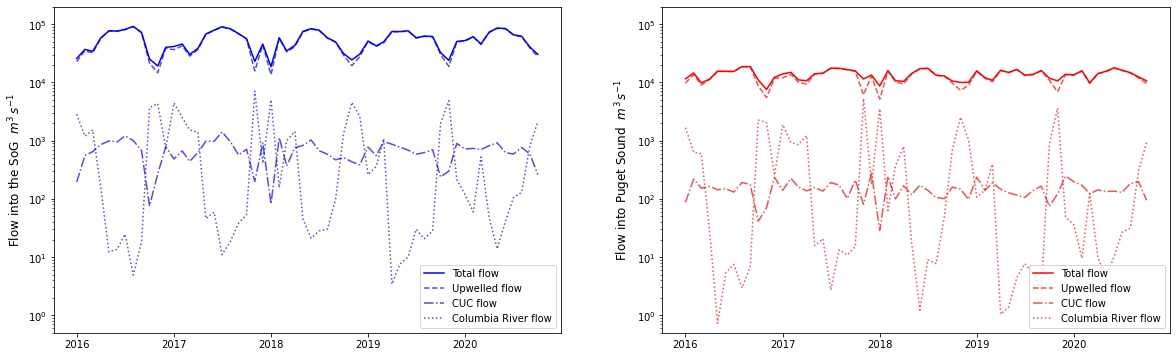

In [31]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
ax[0].plot(dates, SoG, 'b', label='Total flow')
ax[0].plot(dates, upSOG, 'b--', alpha = 0.7, label = 'Upwelled flow')
ax[0].plot(dates, cucSOG, 'b', alpha = 0.7, label='CUC flow', ls='dashdot')
ax[0].plot(dates, freshSOG, 'b', alpha = 0.7, label='Columbia River flow', ls='dotted')
ax[0].set_yscale('log')
ax[0].set_ylabel('Flow into the SoG  $m^3\,s^{-1}$', fontsize=12)
ax[0].legend(loc='lower right')
ax[0].set_ylim([0.5,200000])

ax[1].plot(dates, PS, 'r', label='Total flow')
ax[1].plot(dates, upPS, 'r--', alpha = 0.7, label = 'Upwelled flow')
ax[1].plot(dates, cucPS, 'r', alpha = 0.7, label='CUC flow', ls='dashdot')
ax[1].plot(dates, freshPS, 'r', alpha = 0.7, label='Columbia River flow', ls='dotted')
ax[1].set_yscale('log')
ax[1].set_ylabel('Flow into Puget Sound  $m^3\,s^{-1}$', fontsize=12)
ax[1].legend(loc='lower right')
ax[1].set_ylim([0.5,200000])


## lets draw where the upwelled and CUC water mass enter the channels